# 20th

## Probabilistic model

Epoch 01/100  loss 0.0088
Epoch 05/100  loss 0.0126
Epoch 10/100  loss 0.0031
Epoch 15/100  loss 0.0033
Epoch 20/100  loss 0.0040
Epoch 25/100  loss 0.0017
Epoch 30/100  loss 0.0017
Epoch 35/100  loss 0.0015
Epoch 40/100  loss 0.0016
Epoch 45/100  loss 0.0023
Epoch 50/100  loss 0.0018
Epoch 55/100  loss 0.0018
Epoch 60/100  loss 0.0013
Epoch 65/100  loss 0.0014
Epoch 70/100  loss 0.0009
Epoch 75/100  loss 0.0021
Epoch 80/100  loss 0.0019
Epoch 85/100  loss 0.0019
Epoch 90/100  loss 0.0024
Epoch 95/100  loss 0.0023
Epoch 100/100  loss 0.0011

Hold-out RMSE: 2.726394


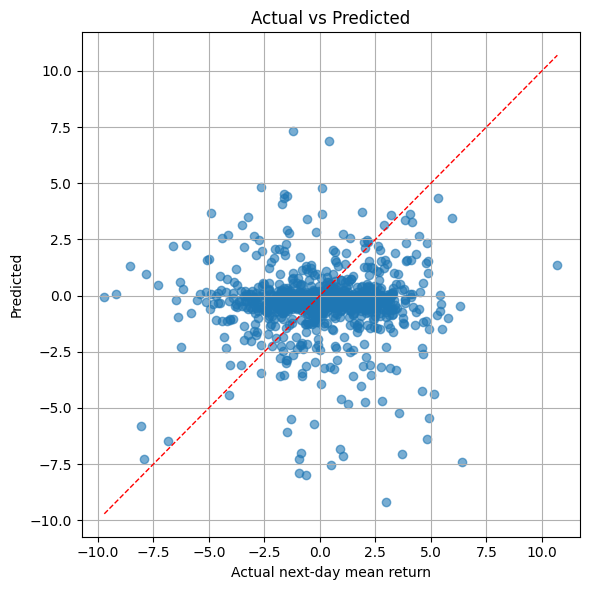

In [5]:
# prob_model_simplified.py
# ------------------------
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

CSV        = '../../data/dataV.csv'
WIN        = 10
TRAIN_FRAC = 0.8
BATCH      = 32
EPOCHS     = 100
LR         = 1e-3
device     = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Load & features ----------------------------------------------------------
df = (pd.read_csv(CSV, parse_dates=['Date'])
        .sort_values('Date')
        .reset_index(drop=True))

v = df['returns'].astype('float32')
df['sd']      = v.rolling(WIN).std(ddof=1)
df['sd_mean'] = df['sd'].rolling(WIN).mean()
df = df.dropna(subset=['returns', 'sd', 'sd_mean']).reset_index(drop=True)
feat_cols = ['sd', 'returns', 'sd_mean']

# 2) Chronological split ------------------------------------------------------
split   = int(len(df) * TRAIN_FRAC)
train_d = df.iloc[:split].copy()
test_d  = df.iloc[split:].copy()

# 3) Fit scalers on TRAIN ONLY -----------------------------------------------
scaler_X = StandardScaler().fit(train_d[feat_cols])
scaler_y = StandardScaler().fit(train_d[['returns']])

for frame in (train_d, test_d):
    frame[feat_cols] = scaler_X.transform(frame[feat_cols]).astype('float32')
    frame['returns'] = scaler_y.transform(frame[['returns']]).astype('float32')

# 4) Dataset / loaders --------------------------------------------------------
class SeqDataset(Dataset):
    def __init__(self, frame):
        X, y = frame[feat_cols].to_numpy(np.float32), frame['returns'].to_numpy(np.float32)
        self.samples = [(X[i:i+WIN], y[i+WIN]) for i in range(len(frame)-WIN-1)]
    def __len__(self):  return len(self.samples)
    def __getitem__(self, k):
        x, y = self.samples[k]
        return torch.from_numpy(x), torch.tensor([y], dtype=torch.float32)

train_dl = DataLoader(SeqDataset(train_d), batch_size=BATCH, shuffle=True)
test_dl  = DataLoader(SeqDataset(test_d),  batch_size=BATCH)

# 5) Model --------------------------------------------------------------------
class LSTM1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(3, 64, batch_first=True)
        self.fc   = nn.Linear(64, 1)
    def forward(self, x):
        return self.fc(self.lstm(x)[0][:, -1])

model = LSTM1().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
crit  = nn.MSELoss()

# 6) Train --------------------------------------------------------------------
for ep in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        loss = crit(model(xb), yb)
        opt.zero_grad(); loss.backward(); opt.step()
    if ep % 5 == 0 or ep == 1:
        print(f'Epoch {ep:02d}/{EPOCHS}  loss {loss.item():.4f}')

# 7) Predict / inverse-scale --------------------------------------------------
model.eval(); P_s, T_s = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        P_s.append(model(xb.to(device)).cpu())
        T_s.append(yb)
P = scaler_y.inverse_transform(torch.cat(P_s).numpy())
T = scaler_y.inverse_transform(torch.cat(T_s).numpy())

rmse = np.sqrt(mean_squared_error(T, P))
print(f'\nHold-out RMSE: {rmse:.6f}')

# 8) Plot Actual vs Pred ------------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(T, P, alpha=.6)
lims = [min(T.min(), P.min()), max(T.max(), P.max())]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.xlabel('Actual next-day mean return')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9) Save predictions back to CSV (optional) ----------------------------------
df.loc[test_d.index[-len(P):], 'ProbL_pred'] = P.ravel()
#df.to_csv(CSV, index=False, float_format='%.6f')


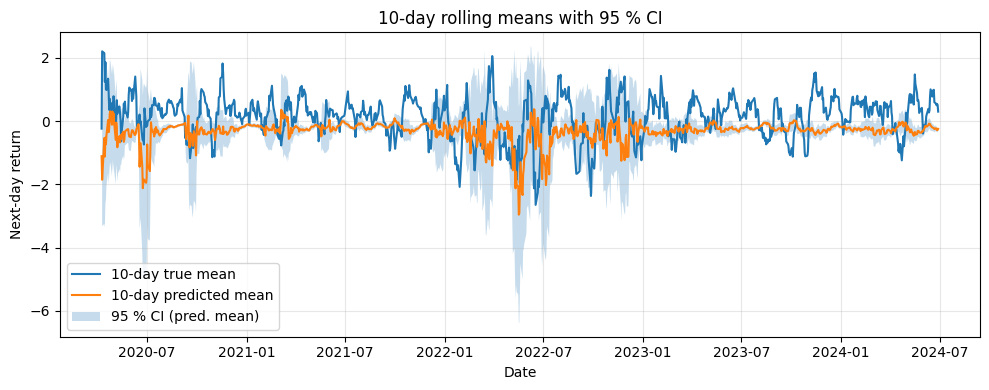

In [7]:
# 8b) Evolution of true-vs-predicted 5-day rolling mean ± 95 % CI ------------
WINDOW = 10  

# Align predictions and ground truth with their dates
pred_dates   = df.loc[test_d.index[-len(P):], 'Date']
true_series  = pd.Series(T.ravel(), index=pred_dates, name='true')
pred_series  = pd.Series(P.ravel(), index=pred_dates, name='pred')

# 5-day rolling means
true_mean = true_series.rolling(WINDOW, min_periods=1).mean()
pred_mean = pred_series.rolling(WINDOW, min_periods=1).mean()

# 5-day rolling stdev of the *predictions* for CI construction
pred_std = pred_series.rolling(WINDOW, min_periods=1).std(ddof=1)

# number of observations in each rolling window (1…WINDOW)
n = np.minimum(np.arange(1, len(pred_series) + 1), WINDOW)

# 95 % two-sided CI: μ̂ ± 1.96·σ/√n
ci95  = 1.96 * pred_std / np.sqrt(n)
lower = pred_mean - ci95
upper = pred_mean + ci95

# Plot
plt.figure(figsize=(10, 4))
plt.plot(true_mean.index, true_mean, label='10-day true mean',  linewidth=1.5)
plt.plot(pred_mean.index, pred_mean, label='10-day predicted mean', linewidth=1.5)
plt.fill_between(pred_mean.index, lower, upper, alpha=0.25,
                 label='95 % CI (pred. mean)')
plt.xlabel('Date')
plt.ylabel('Next-day return')
plt.title('10-day rolling means with 95 % CI')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Option pricing model

### Fair price calculation

In [8]:
#import pandas as pd
#import numpy as np
#
#csv_path = "../../data/dataV.csv"          # original file
#
#df = (pd.read_csv(csv_path, parse_dates=["Date"])
#        .sort_values("Date")
#        .reset_index(drop=True))
#
#
#delta = df["Close"].shift(-1) - df["Close"]          # S_{t+1} – S_t
#df["fair_price"] = 0.5 * delta.abs()  
#
#df.to_csv(csv_path, index=False, float_format="%.5f")

In [9]:
import pandas as pd
import numpy as np

csv_path = "../../data/dataV.csv"

df = (pd.read_csv(csv_path, parse_dates=["Date"])
        .sort_values("Date")
        .reset_index(drop=True))

# ------------------------------------------------------------
# rolling 10-day realised vol (percent → decimal)
#   – shift(1) to avoid look-ahead
# ------------------------------------------------------------
sigma = (df["volatility"] / 100.0).rolling(10).mean().shift(1)

# ------------------------------------------------------------
# 1-day ATM call “fair price”   C ≈ 0.3989 * S * σ * √T
# with  T = 1/252  →   0.3989 * √(1/252) ≈ 0.0252
# ------------------------------------------------------------
ATM_FACTOR = 0.3989422804 / np.sqrt(252)        # 1/√(2π) / √252 ≈ 0.0252
df["fair_price"] = ATM_FACTOR * df["Close"] * sigma


df = df.dropna(subset=["fair_price"]).reset_index(drop=True)

df.to_csv(csv_path, index=False, float_format="%.5f")


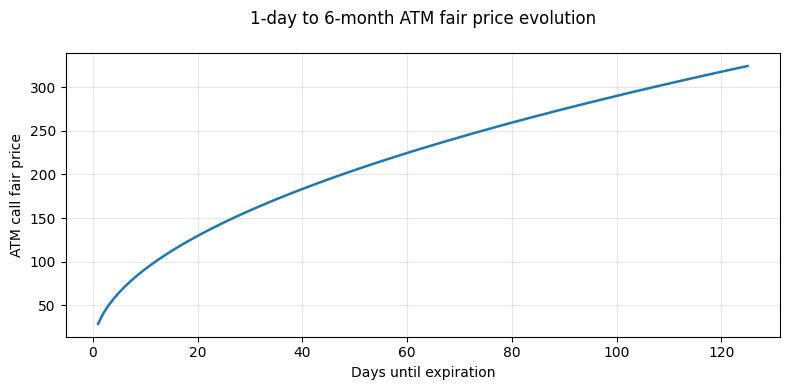

In [10]:
# ------------------------------------------------------------
# 1-day … 6-month ATM fair-price curve  -----------------------
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# --- grab the most recent S and σ ---------------------------
S_last = df.loc[df.index[-1], "Close"]
# realised daily vol → annual
sigma_day  = df['volatility'].iloc[-1] / 100        # 0.0065
sigma_ann  = sigma_day * np.sqrt(252)               # ≈ 0.103

ATM_FACTOR = 0.3989422804                           # 1/√(2π)
days       = np.arange(1, 126)
sqrt_T     = np.sqrt(days / 252)

fair_curve = ATM_FACTOR * S_last * sigma_ann * sqrt_T


# --- plot ---------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(days, fair_curve, lw=1.8)
plt.xlabel("Days until expiration")
plt.ylabel("ATM call fair price")
plt.title("1-day to 6-month ATM fair price evolution\n")
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()


In [11]:
#import pandas as pd
#import numpy as np
#
#csv_path = "../../data/dataV.csv"
#
#df = (pd.read_csv(csv_path, parse_dates=["Date"])
#        .sort_values("Date")
#        .reset_index(drop=True))
#
#delta = df["Close"].shift(-1) - df["Close"]         # S_{t+1} – S_t
#df["fair_price"]   = np.maximum(delta, 0.0)    # realised ATM call
#
##df["true_call_price"]   = np.maximum(delta, 0.0)    # realised ATM call
##df["true_put_price"]    = np.maximum(-delta, 0.0)   # realised ATM put
##df["true_straddle"]     = np.abs(delta)             # call + put
### optional: Black–Scholes ex-post ATM value
##df["bs_ex_post"]        = 0.3989422804 * np.abs(delta)
#
#df.to_csv(csv_path, index=False, float_format="%.5f")

### Base Black-Scholes

In [12]:
# -------------------------------------------------------------------
# 4) 1-day ATM call price via Black-Scholes
# -------------------------------------------------------------------
from scipy.stats import norm
import numpy as np

TRADING_DAYS = 252           # calendar used for annualisation
T = 1 / TRADING_DAYS         # 1-day maturity expressed in years

# σ = mean of the *previous* 10 realised vols (shift → avoid look-ahead bias)
sigma = (df['volatility'] / 100.0).rolling(10).mean().shift(1)
S = df['Close'].astype(float)                     # underlying
K = S                                             # ATM strike
r = df['fed_fund_rate'].astype(float) / 100.0     # annual, in decimals

# Black-Scholes components
sqrtT = np.sqrt(T)
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
d2 = d1 - sigma * sqrtT

# 1-day ATM call price
df['BS_1d_ATM_Call'] = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


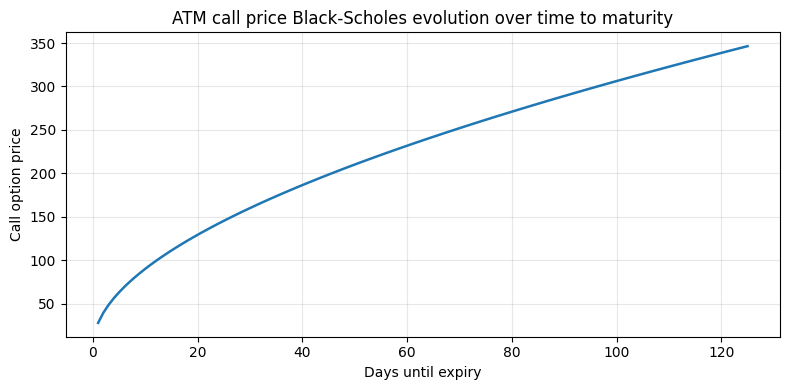

In [15]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm

def bs_price(S, K, r, T, sigma, option='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# ------------------------------------------------------------------
# spot price today
S0 = df['Close'].iloc[-1]        # last row in df
K  = S0                          # ATM strike
r  = 0.03                        # 3 % risk-free
sigma_ann = 0.20                 # 20 % annual vol
days = np.arange(1, 126)         # 1 … 125 business days
T    = days / 252.0              # years to maturity

call_curve = bs_price(S0, K, r, T, sigma_ann)

plt.figure(figsize=(8,4))
plt.plot(days, call_curve, lw=1.8)
plt.xlabel('Days until expiry')
plt.ylabel('Call option price')
plt.title('ATM call price Black-Scholes evolution over time to maturity')
plt.grid(alpha=.3)
plt.tight_layout(); plt.show()


In [ ]:
df.to_csv(csv_path, index=False, float_format="%.5f")

### EMD_vol RNN

Dataset shapes  X: (5349, 20, 2)  y: (5349,)
Epoch   1/100  trainMSE=0.000320  valMSE=0.004424
Epoch  10/100  trainMSE=0.000161  valMSE=0.004671
Epoch  20/100  trainMSE=0.000162  valMSE=0.004445
Epoch  30/100  trainMSE=0.000158  valMSE=0.004277
Epoch  40/100  trainMSE=0.000158  valMSE=0.004553
Epoch  50/100  trainMSE=0.000155  valMSE=0.004282
Epoch  60/100  trainMSE=0.000151  valMSE=0.004542
Epoch  70/100  trainMSE=0.000148  valMSE=0.004605
Epoch  80/100  trainMSE=0.000145  valMSE=0.004509
Epoch  90/100  trainMSE=0.000143  valMSE=0.004601
Epoch 100/100  trainMSE=0.000139  valMSE=0.004681

✓  Wrote vol_preds.csv
     horizon_day  vol_pred
0              1  2.617703
1              2  2.554714
2              3  1.741575
3              4  2.488803
4              5  1.715597
..           ...       ...
121          122  4.185905
122          123  4.220854
123          124  4.235805
124          125  4.226065
125          126  4.194238

[126 rows x 2 columns]


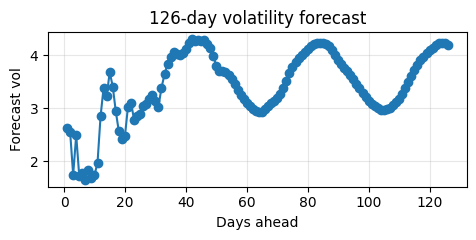

In [1]:
# vol_forecast_to_csv.py  ────────────────────────────────────────────────────
# Train Masked-LSTM on EMD-adaptive windows of realised volatility and
# write an N-day volatility forecast to vol_preds.csv
# --------------------------------------------------------------------------
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from PyEMD import EMD
from scipy.signal import hilbert
import torch, torch.nn as nn, torch.optim as optim

# --------------------------------------------------------------------------
# 1) LOAD & SCALE
# --------------------------------------------------------------------------
CSV_IN = '../../data/dataV.csv'
df     = (pd.read_csv(CSV_IN, parse_dates=['Date'])
            .sort_values('Date', ignore_index=True))

X_raw  = df[['volatility']].values                 # realised vol  (T,1)
y_raw  = df[['volatility_forcast']].values         # next-day vol  (T,1)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).flatten()     # (T,)

# --------------------------------------------------------------------------
# 2) EMD-DRIVEN WINDOW SIZES τ_t
# --------------------------------------------------------------------------
max_W  = 20
imfs   = EMD().emd(X_scaled.flatten())
energies = [np.mean(np.abs(hilbert(imf))**2) for imf in imfs]

inst_pow_norm = sum((np.abs(hilbert(imf))**2) / E
                    for imf, E in zip(imfs, energies))
tau_emd = np.clip(np.round(inst_pow_norm).astype(int), 1, max_W)

# --------------------------------------------------------------------------
# 3) DYNAMIC WINDOWS  (X_dyn, mask)  →  X_with_mask
# --------------------------------------------------------------------------
def build_dyn(X, y, tau, L):
    Xs, Ms, ys = [], [], []
    T, D = X.shape
    for t in range(T):
        w = tau[t]
        if t < w: continue
        win, m = X[t-w:t], np.ones((w,1))
        if w < L:                              # left-pad with zeros
            pad = L - w
            win = np.vstack([np.zeros((pad,D)), win])
            m   = np.vstack([np.zeros((pad,1)), m])
        Xs.append(win);  Ms.append(m);  ys.append(y[t])
    Xs, Ms = np.stack(Xs), np.stack(Ms)
    return np.concatenate([Xs, Ms], axis=2), np.array(ys)

X_mask, y_vec = build_dyn(X_scaled, y_scaled, tau_emd, max_W)
print("Dataset shapes  X:", X_mask.shape, " y:", y_vec.shape)

# --------------------------------------------------------------------------
# 4) TRAIN / TEST  chronological split
# --------------------------------------------------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X_mask, y_vec, test_size=0.2, shuffle=False)

def y_to_seq(y_flat, L):
    Y = np.zeros((len(y_flat), L, 1))
    for i,v in enumerate(y_flat): Y[i,:,0] = v
    return Y
Y_tr, Y_te = y_to_seq(y_tr,max_W), y_to_seq(y_te,max_W)

# --------------------------------------------------------------------------
# 5) MASKED-LSTM MODEL
# --------------------------------------------------------------------------
class MaskedLSTM(nn.Module):
    def __init__(self, D=1, h1=64, h2=32):
        super().__init__()
        self.c1, self.c2 = nn.LSTMCell(D, h1), nn.LSTMCell(h1, h2)
        self.fc = nn.Linear(h2,1)
    def forward(self,xm):
        B,L,_ = xm.size()
        data, m = xm[:,:,:-1], xm[:,:,-1:]
        h1=c1=data.new_zeros(B,64); h2=c2=data.new_zeros(B,32)
        outs=[]
        for t in range(L):
            h1,c1 = self.c1(data[:,t], (h1*m[:,t], c1*m[:,t]))
            h2,c2 = self.c2(h1,        (h2*m[:,t], c2*m[:,t]))
            outs.append(self.fc(h2).unsqueeze(1))
        return torch.cat(outs,1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = MaskedLSTM().to(device)
opt, crit = optim.Adam(model.parameters(),1e-3), nn.MSELoss()

# --------------------------------------------------------------------------
# 6) TRAIN
# --------------------------------------------------------------------------
def to_t(a): return torch.from_numpy(a).float().to(device)
X_tr_t, Y_tr_t, X_te_t, Y_te_t = map(to_t,(X_tr,Y_tr,X_te,Y_te))
EPOCHS, BS = 100, 32
for ep in range(1,EPOCHS+1):
    perm = torch.randperm(len(X_tr_t),device=device)
    run=0
    for i in range(0,len(perm),BS):
        xb, yb = X_tr_t[perm[i:i+BS]], Y_tr_t[perm[i:i+BS]]
        opt.zero_grad(); loss=crit(model(xb), yb); loss.backward(); opt.step()
        run+=loss.item()
    if ep%10==0 or ep==1:
        val=crit(model(X_te_t),Y_te_t).item()
        print(f"Epoch {ep:3d}/{EPOCHS}  trainMSE={run/len(X_tr):.6f}  valMSE={val:.6f}")

# --------------------------------------------------------------------------
# 7) RECURSIVE FORECASTER
# --------------------------------------------------------------------------
def build_tensor(win_raw):
    win_sc = scaler_X.transform(win_raw.reshape(-1,1))
    xm = np.concatenate([win_sc, np.ones_like(win_sc)],1)
    return torch.from_numpy(xm).unsqueeze(0).float().to(device)

def forecast_n(model, last_win_raw, n):
    preds, win = [], last_win_raw.copy()
    model.eval()
    with torch.no_grad():
        for _ in range(n):
            y_sc = model(build_tensor(win))[:, -1, 0].cpu().numpy()
            y_raw= scaler_y.inverse_transform(y_sc.reshape(-1,1))[0,0]
            preds.append(y_raw)
            win=np.roll(win,-1); win[-1]=y_raw
    return preds

# --------------------------------------------------------------------------
# 8) GENERATE & SAVE N-DAY PATH
# --------------------------------------------------------------------------
N_HOR = 126                      # ⬅︎ change horizon here
last_win = df['volatility'].tail(max_W).values
vol_preds = forecast_n(model,last_win,N_HOR)

out = pd.DataFrame({'horizon_day':np.arange(1,N_HOR+1),
                    'vol_pred':vol_preds})
out.to_csv('vol_preds.csv',index=False, float_format='%.6f')
print("\n✓  Wrote vol_preds.csv")
print(out)

# --------------------------------------------------------------------------
# 9) QUICK PLOT
# --------------------------------------------------------------------------
plt.figure(figsize=(5,2.5))
plt.plot(out['horizon_day'], out['vol_pred'], marker='o')
plt.title(f'{N_HOR}-day volatility forecast')
plt.xlabel('Days ahead'); plt.ylabel('Forecast vol')
plt.grid(alpha=.3); plt.tight_layout(); plt.show()


Epoch   1/100 – train MSE: 0.374151
Epoch  10/100 – train MSE: 0.040216
Epoch  20/100 – train MSE: 0.030022
Epoch  30/100 – train MSE: 0.024679
Epoch  40/100 – train MSE: 0.019614
Epoch  50/100 – train MSE: 0.020611
Epoch  60/100 – train MSE: 0.021336
Epoch  70/100 – train MSE: 0.016158
Epoch  80/100 – train MSE: 0.016566
Epoch  90/100 – train MSE: 0.017125
Epoch 100/100 – train MSE: 0.016836

Test RMSE=0.0598  MAE=0.0516  R²=0.9341

Loaded 126-day volatility forecasts from vol_preds.csv

126-day fair-price path: [1.2595 1.3586 1.4275 1.6178 1.7331 1.8569 1.9386 2.0679 2.1059 2.0572
 2.0891 2.195  2.3026 2.4173 2.5571 2.6579 2.7203 2.7395 2.7343 2.7112
 2.7001 2.6818 2.6545 2.6464 2.6468 2.6648 2.6826 2.7028 2.7134 2.7129
 2.7144 2.7363 2.7575 2.7784 2.7992 2.8193 2.8347 2.8484 2.8615 2.8708
 2.8759 2.8787 2.8803 2.8826 2.8847 2.8871 2.8883 2.8878 2.8841 2.8765
 2.8672 2.8585 2.8487 2.8388 2.8285 2.8174 2.8054 2.7932 2.7804 2.7659
 2.7493 2.732  2.7154 2.7012 2.6906 2.6848 2.6839 2.687

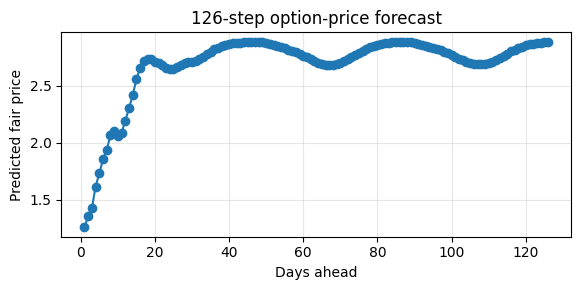

In [2]:
"""
option_price_forecast_from_csv.py
---------------------------------

Train an RNN on historical 1-day ATM call fair-prices and create an N-day
recursive price forecast, using the volatility predictions stored in
vol_preds.csv.

 • Input 1 : ../../data/dataV.csv
 • Input 2 : vol_preds.csv           (written by vol_forecast_to_csv.py)
 • Output  : console metrics + N-day price path plot
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)

# ----------------------------------------------------------------------------
# 1) LOAD MAIN DATA
# ----------------------------------------------------------------------------
CSV_MAIN = '../../data/dataV.csv'
df = (pd.read_csv(CSV_MAIN, parse_dates=['Date'])
        .sort_values('Date', ignore_index=True))

feature_cols = ['EMD_vol', 'Close', 'Volume', 'returns', 'EWMA_VM', 'yang_zhang']
target_col   = 'fair_price'

df = df.dropna(subset=feature_cols + [target_col]).reset_index(drop=True)

X_raw = df[feature_cols].values.astype(np.float32)     # (T,6)
y_raw = df[[target_col]].values.astype(np.float32)     # (T,1)

# ----------------------------------------------------------------------------
# 2) SCALE
# ----------------------------------------------------------------------------
scaler_X, scaler_y = StandardScaler(), StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# ----------------------------------------------------------------------------
# 3) 20-STEP SLIDING WINDOWS
# ----------------------------------------------------------------------------
SEQ_LEN = 20
def make_seqs(X, y, L=SEQ_LEN):
    Xs, ys = [], []
    for t in range(L, len(X)):
        Xs.append(X[t-L:t])
        ys.append(y[t])
    return np.asarray(Xs, np.float32), np.asarray(ys, np.float32)

X_seq, y_seq = make_seqs(X_scaled, y_scaled)

# ----------------------------------------------------------------------------
# 4) CHRONOLOGICAL TRAIN / TEST SPLIT
# ----------------------------------------------------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X_seq, y_seq, test_size=0.20, shuffle=False)

# ----------------------------------------------------------------------------
# 5) DATALOADERS
# ----------------------------------------------------------------------------
BATCH = 32
train_dl = DataLoader(TensorDataset(torch.from_numpy(X_tr),
                                    torch.from_numpy(y_tr)),
                      batch_size=BATCH, shuffle=True)
test_dl  = DataLoader(TensorDataset(torch.from_numpy(X_te),
                                    torch.from_numpy(y_te)),
                      batch_size=BATCH, shuffle=False)

# ----------------------------------------------------------------------------
# 6) MODEL
# ----------------------------------------------------------------------------
class RNNForecast(nn.Module):
    def __init__(self, D=6, h1=64, h2=32, drop=0.2):
        super().__init__()
        self.rnn1 = nn.RNN(D, h1, batch_first=True, nonlinearity='tanh')
        self.rnn2 = nn.RNN(h1, h2, batch_first=True, nonlinearity='tanh')
        self.dp   = nn.Dropout(drop)
        self.fc   = nn.Linear(h2, 1)
    def forward(self, x):
        o1, _ = self.rnn1(x)
        o2, _ = self.rnn2(o1)
        return self.fc(self.dp(o2)[:, -1])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = RNNForecast().to(device)
opt    = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
crit   = nn.MSELoss()

# ----------------------------------------------------------------------------
# 7) TRAIN
# ----------------------------------------------------------------------------
EPOCHS = 100
for ep in range(1, EPOCHS+1):
    model.train(); run = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward(); opt.step()
        run += loss.item()*xb.size(0)
    if ep % 10 == 0 or ep == 1:
        print(f"Epoch {ep:3d}/{EPOCHS} – train MSE: {run/len(train_dl.dataset):.6f}")

# ----------------------------------------------------------------------------
# 8) SINGLE-STEP TEST METRICS
# ----------------------------------------------------------------------------
model.eval()
with torch.no_grad():
    y_hat_sc = model(torch.from_numpy(X_te).to(device)).cpu().numpy()
y_hat = scaler_y.inverse_transform(y_hat_sc)
y_true = scaler_y.inverse_transform(y_te)

print("\nTest RMSE={:.4f}  MAE={:.4f}  R²={:.4f}".format(
      np.sqrt(mean_squared_error(y_true, y_hat)),
      mean_absolute_error(y_true, y_hat),
      r2_score(y_true, y_hat)))

# ----------------------------------------------------------------------------
# 9) LOAD VOLATILITY FORECASTS FROM CSV
# ----------------------------------------------------------------------------
vol_df   = pd.read_csv('vol_preds.csv')
vol_preds = vol_df['vol_pred'].values          # numpy array
N_HOR     = len(vol_preds)
print(f"\nLoaded {N_HOR}-day volatility forecasts from vol_preds.csv")

# ----------------------------------------------------------------------------
# 10) RECURSIVE FAIR-PRICE FORECAST
# ----------------------------------------------------------------------------
def last20_tensor(df_slice):
    X20 = scaler_X.transform(df_slice[feature_cols].values.astype(np.float32))
    return torch.from_numpy(X20).unsqueeze(0).to(device)  # (1,20,6)

def multi_step_price(model, df_work, vol_path, n_steps):
    dfw, outs = df_work.copy(), []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            # ---- build next day row
            row = dfw.iloc[-1].copy()
            row['Date']    += pd.Timedelta(days=1)
            row['returns']  = 0.0            # simple assumption
            row['EMD_vol']  = vol_path[i]    # insert fresh vol forecast
            dfw = pd.concat([dfw, row.to_frame().T], ignore_index=True)

            # ---- predict fair price using last 20 rows
            x20 = last20_tensor(dfw.tail(SEQ_LEN))
            pred_sc = model(x20).cpu().numpy()
            pred_raw= scaler_y.inverse_transform(pred_sc)[0,0]
            outs.append(pred_raw)

            dfw.at[dfw.index[-1], 'Call_EMD_RNN'] = pred_raw
    return outs

price_path = multi_step_price(model, df, vol_preds, N_HOR)
print(f"\n{N_HOR}-day fair-price path:", np.round(price_path,4))

# ----------------------------------------------------------------------------
# 11) PLOT
# ----------------------------------------------------------------------------
plt.figure(figsize=(6,3))
plt.plot(range(1, N_HOR+1), price_path, marker='o')
plt.xlabel("Days ahead"); plt.ylabel("Predicted fair price")
plt.title(f"{N_HOR}-step option-price forecast")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()


In [3]:
# -------------------------------------------------------------------
# 10) Optional linear regression on the clean test set  ← NEW / FIXED
# -------------------------------------------------------------------
from sklearn.linear_model import LinearRegression

# y_test_clean, y_pred_clean were built in section 8 bis
if y_test_clean.size == 0:          # just in case every row was filtered out
    print("No valid samples left for linear regression; skipping.")
else:
    sigma      = y_test_clean.ravel()     # true values
    sigma_hat  = y_pred_clean.ravel()     # model predictions

    linreg = LinearRegression()
    linreg.fit(sigma_hat.reshape(-1, 1), sigma)

    r_squared = linreg.score(sigma_hat.reshape(-1, 1), sigma)
    beta_0    = linreg.intercept_
    beta_1    = linreg.coef_[0]

    print(f"Linear-fit R² : {r_squared:.4f}")
    print(f"β₀ (intercept): {beta_0:.6f}")
    print(f"β₁ (slope)    : {beta_1:.6f}")


NameError: name 'y_test_clean' is not defined

Epoch   1/100 – train MSE: 0.888187
Epoch   2/100 – train MSE: 0.665293
Epoch   3/100 – train MSE: 0.547661
Epoch   4/100 – train MSE: 0.505612
Epoch   5/100 – train MSE: 0.473604
Epoch   6/100 – train MSE: 0.453810
Epoch   7/100 – train MSE: 0.439860
Epoch   8/100 – train MSE: 0.430415
Epoch   9/100 – train MSE: 0.420032
Epoch  10/100 – train MSE: 0.416867
Epoch  11/100 – train MSE: 0.428909
Epoch  12/100 – train MSE: 0.400741
Epoch  13/100 – train MSE: 0.392931
Epoch  14/100 – train MSE: 0.388772
Epoch  15/100 – train MSE: 0.381698
Epoch  16/100 – train MSE: 0.373459
Epoch  17/100 – train MSE: 0.374670
Epoch  18/100 – train MSE: 0.375621
Epoch  19/100 – train MSE: 0.369478
Epoch  20/100 – train MSE: 0.373429
Epoch  21/100 – train MSE: 0.362474
Epoch  22/100 – train MSE: 0.361098
Epoch  23/100 – train MSE: 0.359006
Epoch  24/100 – train MSE: 0.363160
Epoch  25/100 – train MSE: 0.354422
Epoch  26/100 – train MSE: 0.350066
Epoch  27/100 – train MSE: 0.348239
Epoch  28/100 – train MSE: 0

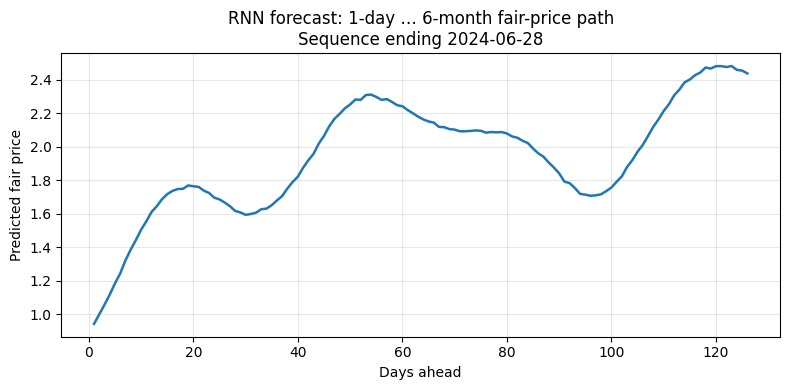

Saved multi-horizon preds (columns RNN_pred_T001 … _T126)


C:\Users\paula\AppData\Local\Temp\ipykernel_10580\1364384224.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[len(df)-1, f"RNN_pred_T{h:03d}"] = price   # one column per horizon
C:\Users\paula\AppData\Local\Temp\ipykernel_10580\1364384224.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[len(df)-1, f"RNN_pred_T{h:03d}"] = price   # one column per horizon
C:\Users\paula\AppData\Local\Temp\ipykernel_10580\1364384224.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
#StandardScaler
# -------------------------------------------------------------------
# 1) Load, sort, *drop NaNs*
# -------------------------------------------------------------------
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

feature_cols = ['EMD_vol', 'Close', 'Volume',
                'returns', 'EWMA_VM', 'yang_zhang']
target_col   = 'fair_price'

# remove every row that has a NaN in *any* required column
df = df.dropna(subset=feature_cols + [target_col]).reset_index(drop=True)

X_raw = df[feature_cols].values          # (T_clean, 6)
y_raw = df[[target_col]].values          # (T_clean, 1)

# -------------------------------------------------------------------
# 2) Scale
# -------------------------------------------------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)


# -------------------------------------------------------------------
# 3) Build sliding-window *multi-horizon* sequences  ### NEW / CHANGED >>>
# -------------------------------------------------------------------
SEQ_LEN       = 20
HORIZON_DAYS  = 126                               # 1 day … 6 months

def create_multihorizon(X, y, seq_len=SEQ_LEN, horizon=HORIZON_DAYS):
    Xs, ys = [], []
    max_t  = len(X) - horizon        # leave room for horizon look-ahead
    for t in range(seq_len, max_t):
        Xs.append(X[t - seq_len:t])
        ys.append(y[t : t + horizon].ravel())  # vector of size HORIZON_DAYS
    return (np.asarray(Xs, np.float32),
            np.asarray(ys, np.float32))

X_seq, y_seq = create_multihorizon(X_scaled, y_scaled)

# -------------------------------------------------------------------
# 4) Chronological train / test split  (unchanged)
# -------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.20, shuffle=False
)

# -------------------------------------------------------------------
# 5) DataLoaders  (tweak output dims)  ### NEW / CHANGED >>>
# -------------------------------------------------------------------
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test)),
    batch_size=batch_size, shuffle=False)

# -------------------------------------------------------------------
# 6) Two-layer RNN → FC(HORIZON)       ### NEW / CHANGED >>>
# -------------------------------------------------------------------
class RNNMultiHorizon(nn.Module):
    def __init__(self, input_dim=6, h1=64, h2=32,
                 horizon=HORIZON_DAYS, dropout=0.2):
        super().__init__()
        self.rnn1 = nn.RNN(input_dim, h1, batch_first=True, nonlinearity='tanh')
        self.rnn2 = nn.RNN(h1,       h2, batch_first=True, nonlinearity='tanh')
        self.dp   = nn.Dropout(dropout)
        self.fc   = nn.Linear(h2, horizon)   # one neuron per horizon step

    def forward(self, x):
        o1, _ = self.rnn1(x)
        o2, _ = self.rnn2(o1)
        o2    = self.dp(o2)
        return self.fc(o2[:, -1, :])          # (B, HORIZON)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = RNNMultiHorizon().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# -------------------------------------------------------------------
# 7) Train  (same loop – loss now averages over 126 outputs)
# -------------------------------------------------------------------
EPOCHS = 100
for ep in range(1, EPOCHS + 1):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    print(f"Epoch {ep:3d}/{EPOCHS} – train MSE: {total/len(train_loader.dataset):.6f}")

# -------------------------------------------------------------------
# 8) Predict *latest* sequence → 126-day curve   ### NEW / CHANGED >>>
# -------------------------------------------------------------------
model.eval()
latest_seq = torch.from_numpy(X_seq[-1:]).to(device)   # shape (1, SEQ_LEN, 6)
with torch.no_grad():
    pred_scaled = model(latest_seq).cpu().numpy().reshape(-1, 1)  # (126,1)
pred_curve = scaler_y.inverse_transform(pred_scaled).ravel()

# -------------------------------------------------------------------
# 9) Plot evolution of predicted fair-price      ### NEW / CHANGED >>>
# -------------------------------------------------------------------
import matplotlib.pyplot as plt
days = np.arange(1, HORIZON_DAYS + 1)

plt.figure(figsize=(8, 4))
plt.plot(days, pred_curve, lw=1.8)
plt.xlabel("Days ahead")
plt.ylabel("Predicted fair price")
plt.title("RNN forecast: 1-day … 6-month fair-price path\n"
          f"Sequence ending {df['Date'].iat[-1].date()}")
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 10) (Optional) save the 126-day forecast to the CSV
# -------------------------------------------------------------------
for h, price in zip(days, pred_curve):
    df.at[len(df)-1, f"RNN_pred_T{h:03d}"] = price   # one column per horizon

#df.to_csv('../../data/dataV.csv', index=False,
         # float_format="%.5f")
print("Saved multi-horizon preds (columns RNN_pred_T001 … _T126)")


### Result


=== Error metrics (lower is better) ===
                        MSE     MAE      R²
Call_EMD_RNN         0.0014  0.0274  0.9749
Call_base_RNN        0.0025  0.0406  0.9812
Call_LSTM_RNN        0.0178  0.1180  0.9276
BS_1d_ATM_Call       0.3619  0.5990  0.9468
LSTM_BS_1d_ATM_Call  0.7245  0.8379  0.6623
EMD_BS_1d_ATM_Call   1.0056  0.9786  0.1527


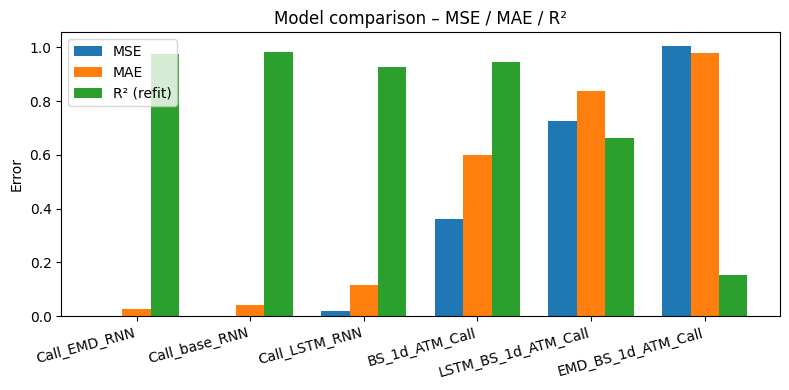

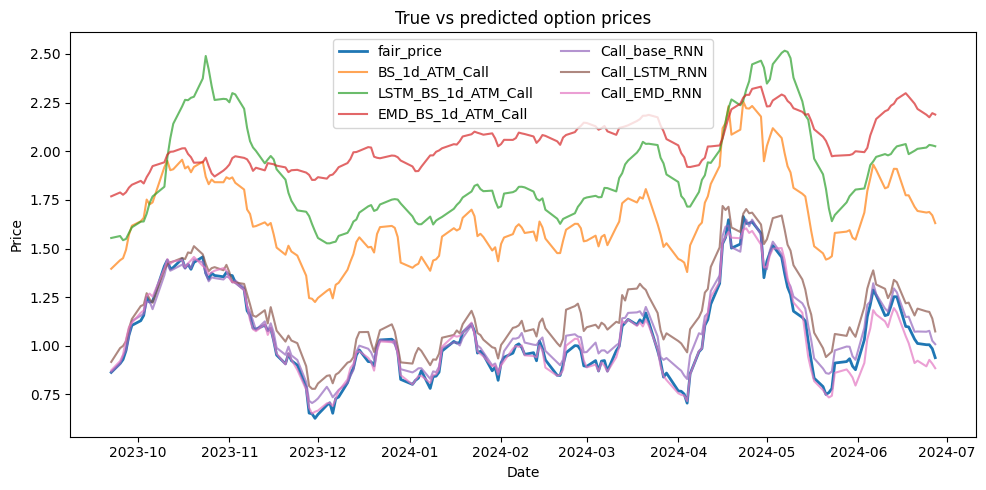

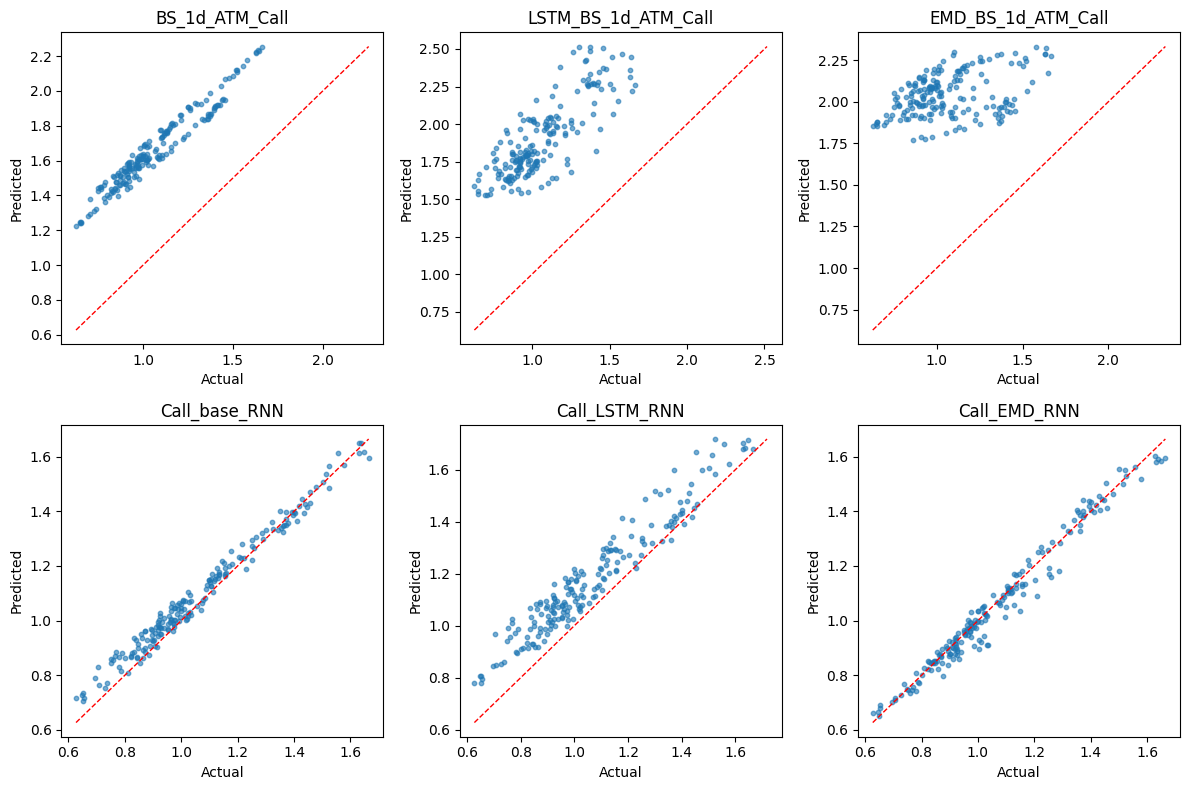

In [17]:
# compare_option_pricing_fixed_r2.py
# ----------------------------------
import pathlib, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

CSV_PATH = pathlib.Path('../../data/dataV.csv')

# -------------------------------------------------------------------
# 1) Load & clean
# -------------------------------------------------------------------
cols_pred = [
    'BS_1d_ATM_Call',
    'LSTM_BS_1d_ATM_Call',
    'EMD_BS_1d_ATM_Call',
    'Call_base_RNN',
    'Call_LSTM_RNN',
    'Call_EMD_RNN'
]
target = 'fair_price'

df = pd.read_csv(CSV_PATH, parse_dates=['Date'])
df_clean = df.dropna(subset=cols_pred + [target]).reset_index(drop=True)

y_true = df_clean[target].values
dates  = df_clean['Date']

# -------------------------------------------------------------------
# 2) Metrics with *refit-R²*
# -------------------------------------------------------------------
metrics = {}
for col in cols_pred:
    y_pred = df_clean[col].values

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # ---- R² via linear regression refit (your snippet) -------------
    linreg = LinearRegression()
    linreg.fit(y_pred.reshape(-1, 1), y_true)
    r2 = linreg.score(y_pred.reshape(-1, 1), y_true)

    metrics[col] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# tidy frame
metrics_df = (pd.DataFrame(metrics).T
                .sort_values('MSE')
                .round(4))

print('\n=== Error metrics (lower is better) ===')
print(metrics_df)

# -------------------------------------------------------------------
# 3) Bar chart
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))
w = 0.25; x = np.arange(len(cols_pred))
ax.bar(x - w, metrics_df['MSE'],  w, label='MSE')
ax.bar(x,       metrics_df['MAE'], w, label='MAE')
ax.bar(x + w, metrics_df['R²'],   w, label='R² (refit)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df.index, rotation=15, ha='right')
ax.set_ylabel('Error')
ax.set_title('Model comparison – MSE / MAE / R²')
ax.legend()
plt.tight_layout(); plt.show()

# -------------------------------------------------------------------
# 4) Time-series plot
# -------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(dates, y_true, label='fair_price', linewidth=2)
for col in cols_pred:
    plt.plot(dates, df_clean[col], label=col, alpha=0.7)
plt.title('True vs predicted option prices')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(ncol=2); plt.tight_layout(); plt.show()

# -------------------------------------------------------------------
# 5) Scatter grid (Actual vs Predicted)
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 8)); axes = axes.ravel()
for ax, col in zip(axes, cols_pred):
    y_pred = df_clean[col].values
    ax.scatter(y_true, y_pred, alpha=0.6, s=10)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', linewidth=1)
    ax.set_title(col)
    ax.set_xlabel('Actual'); ax.set_ylabel('Predicted')
plt.tight_layout(); plt.show()


In [18]:
df[['fair_price', 'BS_1d_ATM_Call']].describe().T[['min','mean','max']]


,min,mean,max
fair_price,0.62712,1.059348,1.66462
BS_1d_ATM_Call,1.22490,1.652997,2.25529


In [19]:
df['BS_1d_ATM_Call'].head(15)


0     1.68084
1     1.72726
2     1.81280
3     1.80969
4     1.87009
5     1.82048
6     1.74371
7     1.71638
8     1.63253
9     1.65501
10    1.61028
11    1.48187
12    1.37994
13    1.39408
14    1.30867
Name: BS_1d_ATM_Call, dtype: float64

In [20]:
df['fair_price'].head(15)


0     1.15992
1     1.20461
2     1.29030
3     1.27831
4     1.33899
5     1.28822
6     1.20667
7     1.18055
8     1.09634
9     1.12218
10    1.07385
11    0.93155
12    0.82364
13    0.83844
14    0.73638
Name: fair_price, dtype: float64